In [72]:
#Attach Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
#All Imports
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os as os

%matplotlib inline
import matplotlib.pyplot as plt

import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import models

import random
import collections
import shutil
import glob
import csv
import pandas as pd

from PIL import Image
from google.colab import files

import copy

In [102]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)

        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x


# create a complete CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): LogSoftmax()
)


In [0]:
#load the data
data_path = '/content/gdrive/My Drive/IDP_SC/data/balanced-tiny'
#saved model path
model_path = '/content/gdrive/My Drive/IDP/savedmodels/'
current_model_name = 'model_scv4.pt'
traind_model_name = 'model_scv2.pt'


In [0]:
#move to CUDA if available 
train_on_gpu = torch.cuda.is_available() #will return true if gpu available
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda() # if gpu available train on gpu

In [105]:
#load previous trained model if its available
model.load_state_dict(torch.load(trained_model_path))
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): LogSoftmax()
)

In [0]:
#Hyper Parameters


# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
test_size = 0.3 #30 percent for the test
valid_size = 0.2 #20 percent for the validation
#everything else in the tarining

# number of epochs to train the model
n_epochs = 50 # you may increase this number to train a final model

#define the earning rate
lr = 0.00001
#define the momentum
momentum= 0.9

#use weighted cross entropy loss
neg_reward= 0.2
positive_reward= 0.8

#define the reword for wetedcross entropy loss
weights = torch.tensor([neg_reward, positive_reward])
class_weights = torch.FloatTensor(weights).cuda()

# specify loss function
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weight)

# specify optimizer

#Use SGD
#optimizer = torch.optim.SGD(model.parameters(), lr, momentum)

#or use Adam any one of them
optimizer = torch.optim.Adam(model.parameters(), lr)

In [107]:
#check if all the paths is working

#check total number of positive data
pos = sum([len(files) for r, d, files in os.walk(data_path + '/pos')])
print(pos)

#check total number of negetive data
neg = sum([len(files) for r, d, files in os.walk(data_path + '/neg')])
print(neg)


current_model_path = model_path + current_model_name
trained_model_path = model_path + traind_model_name
print(current_model_path)
print(trained_model_path)

112
112
/content/gdrive/My Drive/IDP/savedmodels/model_scv4.pt
/content/gdrive/My Drive/IDP/savedmodels/model_scv2.pt


In [108]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(), #dont neet to flip because website never show fliped image
    #transforms.RandomRotation(20), #dont neet to rotate because website never show rotated image
    transforms.Resize(size=(224,224)), #make sure all pictures are in this size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

#transform all datat in the folder
data = datasets.ImageFolder(root= data_path, transform=transform)

#check the transpromed data data
data

Dataset ImageFolder
    Number of datapoints: 224
    Root location: /content/gdrive/My Drive/IDP_SC/data/balanced-tiny

In [0]:
#devide the datas according to setup

#For test
num_data = len(data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

#For Valid
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#make train, valid and test loader for training
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(data, sampler = test_sampler, batch_size=batch_size, 
    num_workers=1)

#Define classes
classes = [0,1]

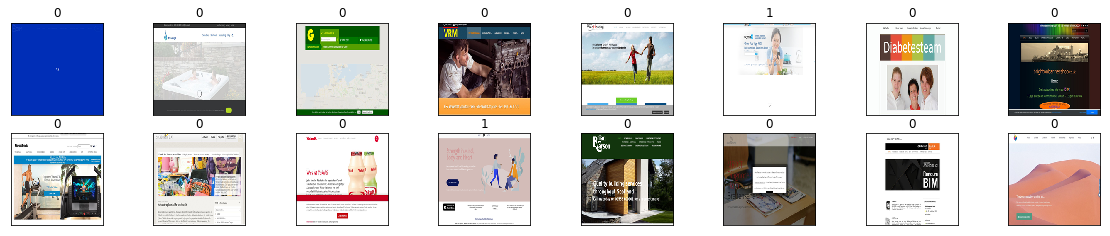

In [110]:
#preview the data

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20,20))
# display 64 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(10, batch_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [111]:
#evaluate training time
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

valid_loss_min = np.Inf # track change in validation loss
train_loss_history = []
valid_loss_history = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    #save them in an array
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_scv2.pt')
        #saving the model in google drive
        path = F"{current_model_path}" 
        torch.save(model.state_dict(), path)
        valid_loss_min = valid_loss

end.record() 
# Waits for everything to finish running
torch.cuda.synchronize()


Epoch: 1 	Training Loss: 0.291971 	Validation Loss: 0.080955
Validation loss decreased (inf --> 0.080955).  Saving model ...
Epoch: 2 	Training Loss: 0.293298 	Validation Loss: 0.073662
Validation loss decreased (0.080955 --> 0.073662).  Saving model ...
Epoch: 3 	Training Loss: 0.298141 	Validation Loss: 0.072799
Validation loss decreased (0.073662 --> 0.072799).  Saving model ...
Epoch: 4 	Training Loss: 0.269872 	Validation Loss: 0.071293
Validation loss decreased (0.072799 --> 0.071293).  Saving model ...
Epoch: 5 	Training Loss: 0.261894 	Validation Loss: 0.076260
Epoch: 6 	Training Loss: 0.240473 	Validation Loss: 0.066657
Validation loss decreased (0.071293 --> 0.066657).  Saving model ...
Epoch: 7 	Training Loss: 0.242757 	Validation Loss: 0.072659
Epoch: 8 	Training Loss: 0.222901 	Validation Loss: 0.067620
Epoch: 9 	Training Loss: 0.224136 	Validation Loss: 0.072503
Epoch: 10 	Training Loss: 0.205489 	Validation Loss: 0.069325
Epoch: 11 	Training Loss: 0.203034 	Validation Lo

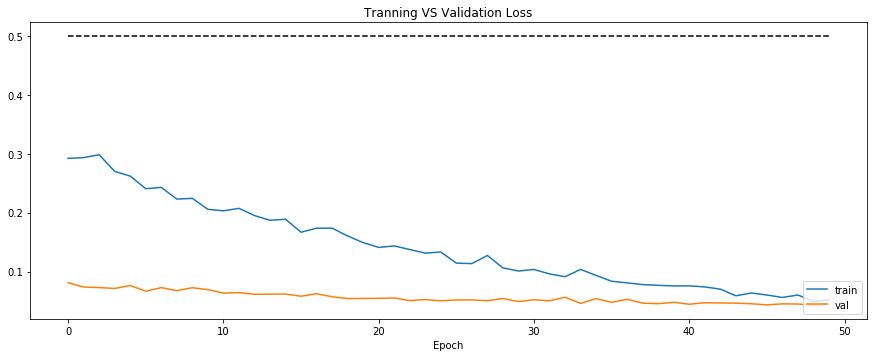

In [112]:
#show the validation vs training loss


#norm_train_loss = [x*100 for x in train_loss_history]
#norm_valid_loss = [x*100 for x in valid_loss_history]

plt.subplot(2, 1, 2)
plt.title('Tranning VS Validation Loss')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='val')
plt.plot([0.5] * len(valid_loss_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
i=1
# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
#     print(target)
    
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))



print('\nTraining Time')
print(start.elapsed_time(end)/1000)

Test Loss: 0.172251

Test Accuracy of     0: 81% (27/33)
Test Accuracy of     1: 70% (22/31)

Test Accuracy (Overall): 76% (49/64)

Training Time
553.7700625


In [0]:
#predicter which save in csv

predicted_data = []

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

model_name = 'model_scv2.pt'
path = F"/content/gdrive/My Drive/IDP/savedmodels/{model_name}"
model.load_state_dict(torch.load(path))
model.eval()


PATH_OF_UNLABELED_DATA= '/content/gdrive/My Drive/IDP_SC/unlabeled_63k'
#!ls {PATH_OF_UNLABELED_DATA}

#open csv to write

with open("/content/gdrive/My Drive//IDP_SC/predicted.csv", "w") as csvfile:
    writer = csv.writer(csvfile, delimiter=",", lineterminator='\n')
    writer.writerow(['image','link', 'Startup probability', 'prediction'])
    

start = time.time()
i=0
for filename in os.listdir(PATH_OF_UNLABELED_DATA):
    pred_list = []
    if filename.endswith("jpeg"): 
        
        #print(filename)
        path_single_image = F"/content/gdrive/My Drive/IDP_SC/unlabeled_63k/{filename}"
        single_image_data=image_loader(data_transforms, path_single_image)

        #print(single_image_data)

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            single_image_data, target = single_image_data.cuda(), single_image_data.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model

        output = model(single_image_data)
        smax = nn.Softmax()
        smax_out = smax(output)[0]
        non_startup_prob = smax_out.data[0]
        startup_prob = smax_out.data[1]
        prob = startup_prob
        if non_startup_prob > startup_prob:
            prob = 1 - non_startup_prob
        prob = np.around(prob.cpu(), decimals=4)
#         prob=prob.tolist()[0]
#         prob = np.clip(prob, clip, 1-clip)
        
        
        prob= np.around(prob.item(), decimals=4)
        
      
        
        if prob > 0.6 :
          prediction_label = 'positive'
        else:
          prediction_label = 'negetive'
          
        if(i % 100 == 0):
          print(str(i)+ "--" + filename + "--" + str(prob) + "--" + prediction_label)
        
        pred_list = [filename, "", prob, prediction_label]
        
        with open("/content/gdrive/My Drive//IDP_SC/predicted.csv", "a") as csvfile:
            writer = csv.writer(csvfile, delimiter=",", lineterminator='\n')
            writer.writerow(pred_list)
        #predicted_data.append(pred_list)
        i += 1
        
# print(predicted_data)

   
# panda_predicted_dataframe = pd.DataFrame(predicted_data, columns=['image','link', 'Startup probability', 'prediction'])

# with open("/content/gdrive/My Drive//IDP_SC/predicted.csv", "w") as my_empty_csv:
#   # now you have an empty file already
#   pass  # or write something to it already

# panda_predicted_dataframe.to_csv('/content/gdrive/My Drive/IDP_SC/predicted.csv', mode='a', header=True)
end = time.time()


print("Done.")
print("Time elasped")
print(end - start)